In [1]:
%matplotlib inline
from icepyx import icesat2data as ipd
import os
import shutil
from pathlib import Path
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt

# Download ATL06 data

In [4]:
short_name = 'ATL06'
spatial_extent = [ -50.71,  65.73, -45.32,  68.08] # [Ll lon, ll lat, ur lon, ur lat]
date_range = ['2019-06-01','2019-06-10']

In [5]:
region_a = ipd.Icesat2Data(short_name, spatial_extent, date_range)

# print(region_a.dataset)
# print(region_a.dates)
# print(region_a.start_time)
# print(region_a.end_time)
# print(region_a.dataset_version)
# print(region_a.spatial_extent)

In [6]:
region_a.avail_granules(ids=True)

# # All possible variables
# region_a.order_vars.avail(options=True)

['ATL06_20190601071608_09780303_003_01.h5',
 'ATL06_20190601200102_09860305_003_01.h5',
 'ATL06_20190605070748_10390303_003_01.h5',
 'ATL06_20190605195242_10470305_003_01.h5',
 'ATL06_20190609065929_11000303_003_01.h5',
 'ATL06_20190609194422_11080305_003_01.h5']

In [7]:
earthdata_emails = {'tsnow03':'tasha.snow@colorado.edu',
                 'fperez': 'fernando.perez@berkeley.edu',
                 'alicecima':'alice_cima@berkeley.edu',
                 'grigsbye':'grigsby@mines.edu'
                    # add your name here
                }

user = 'tsnow03'
region_a.earthdata_login(user, earthdata_emails[user])

KeyboardInterrupt: Interrupted by user

In [82]:
region_a.order_vars.append(var_list=['latitude','longitude','h_li','h_li_sigma','atl06_quality_summary','delta_time',
                                      'signal_selection_source','snr_significance','h_robust_sprd','dh_fit_dx','bsnow_conf',
                                      'cloud_flg_asr','cloud_flg_atm','msw_flag','bsnow_h','bsnow_od','layer_flag','bckgrd',
                                      'e_bckgrd','n_fit_photons','end_geoseg','segment_id','w_surface_window_final'])
from IPython.display import JSON
JSON(region_a.order_vars.wanted)

<IPython.core.display.JSON object>

Now, specify our coverage request with the wanted variables:

In [83]:
# Prescribe subset
region_a.subsetparams(Coverage=region_a.order_vars.wanted);

# Order granules
region_a.order_granules()

# # View a short list of order IDs:
# region_a.granules.orderIDs

# Download to path
path = './download'
# without variable subsetting, or with variable subsetting if you have run region_a.order_granules(Coverage=region_a.order_vars.wanted)
region_a.download_granules(path)

Total number of data order requests is  1  for  6  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000702448
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000702448 of  1  order(s) is downloaded.
Download complete


In [84]:
# folder size
!du -csh ./download

19M	./download
19M	total


# Build Pandas DataFrame

Some utility functions

In [8]:
import pyproj
from astropy.time import Time

def gps2dyr(time):
    """Converts GPS time to datetime (can also do decimal years)."""
    return Time(time, format='gps').datetime

def transform_coord(proj1, proj2, x, y):
    """Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projections:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert

In [31]:
import h5py
import numpy as np

def read_atl06(fname,cloud_var='Integer_Cloud_Mask',toff_var='VIIRS_offset',outdir='data', bbox=None):
    """Read one ATL06 file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL06 file 
    into each beam (ground track) and ascending/descending orbits.
    """

    # Each beam is a group
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']
    
    # Loop trough beams
    dataframes = []  # one dataframe per track
    
    with h5py.File(fname, 'r') as fi:
        # Check which ground tracks are present in this file
        gtracks = sorted(['/'+k for k in fi.keys() if k.startswith('gt')])
    
        for k, g in enumerate(gtracks): 
            # Read in data for a single beam
            data = {}
            data['ground_track'] = np.nan # Put it first in the dict for column ordering
            data['t_year'] = np.nan
            
            # Load vars into memory (include as many as you want)
            data['lat'] = fi[g+'/land_ice_segments/latitude'][:]
            data['lon'] = fi[g+'/land_ice_segments/longitude'][:]
            data[cloud_var] = np.nan
            data[toff_var] = np.nan
            data['h_li'] = fi[g+'/land_ice_segments/h_li'][:]
            data['s_li'] = fi[g+'/land_ice_segments/h_li_sigma'][:]
            data['q_flag'] = fi[g+'/land_ice_segments/atl06_quality_summary'][:]
            data['s_fg'] = fi[g+'/land_ice_segments/fit_statistics/signal_selection_source'][:]
            data['snr'] = fi[g+'/land_ice_segments/fit_statistics/snr_significance'][:]
            data['h_rb'] = fi[g+'/land_ice_segments/fit_statistics/h_robust_sprd'][:]
            data['dh_fit_dx'] = fi[g+'/land_ice_segments/fit_statistics/dh_fit_dx'][:]
            data['bsnow_conf'] = fi[g+'/land_ice_segments/geophysical/bsnow_conf'][:]
            
            data['cloud_flg_asr'] = fi[g+'/land_ice_segments/geophysical/cloud_flg_asr'][:]
            data['cloud_flg_atm'] = fi[g+'/land_ice_segments/geophysical/cloud_flg_atm'][:]
            data['msw_flag'] = fi[g+'/land_ice_segments/geophysical/msw_flag'][:]
            data['fbsnow_h'] = fi[g+'/land_ice_segments/geophysical/bsnow_h'][:]
            data['bsnow_od'] = fi[g+'/land_ice_segments/geophysical/bsnow_od'][:]
            data['layer_flag'] = fi[g+'/land_ice_segments/geophysical/layer_flag'][:]
            data['bckgrd'] = fi[g+'/land_ice_segments/geophysical/bckgrd'][:]
            data['e_bckgrd'] = fi[g+'/land_ice_segments/geophysical/e_bckgrd'][:]
            data['n_fit_photons'] = fi[g+'/land_ice_segments/fit_statistics/n_fit_photons'][:]
#             data['end_geoseg'] = fi['/ancillary_data/end_geoseg'][:]
            data['segment_id'] = fi[g+'/segment_quality/segment_id'][:]
            data['w_surface_window_final'] = fi[g+'/land_ice_segments/fit_statistics/w_surface_window_final'][:]
            
            delta_t = fi[g+'/land_ice_segments/delta_time'][:]     # for time conversion
            t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:]     # single value
            
#             data['dac'] = fi[g+'/land_ice_segments/geophysical/dac'][:]
#             data['tide_earth'] = fi[g+'/land_ice_segments/geophysical/tide_earth'][:]
#             data['tide_load'] = fi[g+'/land_ice_segments/geophysical/tide_load'][:]
#             data['tide_ocean'] = fi[g+'/land_ice_segments/geophysical/tide_ocean'][:]
#             data['tide_pole'] = fi[g+'/land_ice_segments/geophysical/tide_pole'][:]
                
#              rgt = fi['/orbit_info/rgt'][:]                           # single value
#              beam_type = fi[g].attrs["atlas_beam_type"].decode()      # strong/weak (str)
#              spot_number = fi[g].attrs["atlas_spot_number"].decode()  # number (str)
            
            # Time in GPS seconds (secs since Jan 5, 1980)
            t_gps = t_ref + delta_t

            # GPS sec to datetime
            data['t_year'] = gps2dyr(t_gps)
        
            # Assume all vector fields are of the length of the first. TODO - check?
            npts = len(data['lat'])
            data['ground_track'] = [g[1:]]*npts
                    
            # Make a dataframe out of our data dict and store it.
            dataframes.append(pd.DataFrame.from_dict(data))
        
    return dataframes

def atl06_2_df(files,cloud_var='Integer_Cloud_Mask',toff_var='VIIRS_offset'):
    """Return a single Pandas dataframe from a list of HDF5 ATL-06 data files.
    """
    dataframes = []
    for f in files:
        dataframes.extend(read_atl06(f,cloud_var,toff_var))
    
    ndfs = len(dataframes)
    i = 0
    
    # pd.concat can only work with up to 10 dataframes at a time,
    # so we need to chunk this up
    new_dfs = []
    while i <= ndfs:
        i_end = i+10 if i+10 < ndfs else ndfs
        dfs = dataframes[i:i_end]
        if not dfs:
            break
        new_dfs.append(pd.concat(dfs))
        i = i_end
    
    return pd.concat(new_dfs)

In [34]:
# Create dataframe from all h5 files and add a column for the imported cloud variable
path = Path('download')
cloud_var = 'Integer_Cloud_Mask'
cld_t_var = 'VIIRS_offset'
dataf = atl06_2_df(path.glob('*.h5'),cloud_var,cld_t_var)
dataf = dataf.reset_index()
del dataf['index']

# dataf.describe()
# dataf.info()
dataf.head(2)

,ground_track,t_year,lat,lon,Integer_Cloud_Mask,VIIRS_offset,h_li,s_li,q_flag,s_fg,...,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,segment_id,w_surface_window_final
0,gt1l,2019-06-01 20:04:48.205868,68.079999,-47.455941,NaN,NaN,1681.167114,0.008938,0,0,...,0,0,3.402823e+38,3.402823e+38,0,7417902.0,2635365.75,507,623016,3.0
1,gt1l,2019-06-01 20:04:48.208686,68.079821,-47.455997,NaN,NaN,1681.033203,0.012630,0,0,...,0,0,3.402823e+38,3.402823e+38,0,7494146.0,2635369.50,531,623017,3.0


In [127]:
dataf.q_flag.value_counts()

0    368002
1     27185
Name: q_flag, dtype: int64

In [128]:
dataf.cloud_flg_asr.value_counts()

2    150480
1     93532
5     71058
3     49528
4     26321
0      4268
Name: cloud_flg_asr, dtype: int64

# Automation of VIIRS assimilation

In [12]:
import utils
import importlib
importlib.reload(utils)
# from utils import associate
import datetime as dt
from sklearn.neighbors import BallTree

In [93]:
def get_file_in_directory(path): 
    "Retrieves file names from a directory \
    \n\nInput: path = directory \
    \n\nOutput: list of subdirectories"

    return [os.path.join(path, name) for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]

def print_attrs(name, obj):
    '''Retrieves all attributes from hd5 file
    Use: f.visititems(print_attrs)
    '''
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))
        

####################################

def associate2(dataframe, swath, variable='Integer_Cloud_Mask'):
    """Takes a dataframe, and a satellite file, and extracts the
    selected variable as a new column.

    Assumes that data coordinates are in lat/lon
    Assumes dataframe higher resolution than swath
    
    swath = satellite data
    """
    
    # grab swath coordinates
    # TODO; make general for inferring lat/lon paths
    latS = np.array(swath['geolocation_data']['latitude'])
    lonS = np.array(swath['geolocation_data']['longitude'])

    S_rad = np.vstack([lonS[:].ravel(),latS[:].ravel()]).T
    S_rad *= np.pi / 180.

    # grab dataframe coords
    latF = dataframe.lat.values
    lonF = dataframe.lon.values

    F_rad = np.vstack([lonF[:].ravel(),latF[:].ravel()]).T
    F_rad *= np.pi / 180.

    # build spatial tree; find matches
    print("building tree")
    S_Ball = BallTree(S_rad,metric='haversine')
    print("searching data")
    indicies = S_Ball.query(F_rad, k=1,
                            breadth_first=True,
                            return_distance=False)
    
    extract = swath['geophysical_data'][variable].value
    new_column = extract.ravel()[indicies]

    # get data for overlay
    shp = swath['geophysical_data'][variable].shape
    mask = np.zeros_like(extract, dtype=bool)
    mask.ravel()[indicies] = True
    
    return new_column, mask, indicies

####################################

def assimVIIRS(df, Cfiles, hr=1, cl_var='Integer_Cloud_Mask',toff_var='VIIRS_Offset'):
    '''Read in each VIIRS cloud mask file and assimilate the data from it
    for the Icesat-2 data points that coincide in time (within a window) and space. Offset
    in time is calculated.
    
    df = Pandas DataFrame of Icesat-2 data
    Cfiles = list of VIIRS file paths
    hr = hours, temporal search window
    cl_var = column name for VIIRS data
    toff_var = column name for time offset between VIIRS and Icesat-2 data
    '''
    
    for Cfile in Cfiles:
        f_ = h5py.File(Cfile) 
        f_t = int(Cfile[-33:-26]+Cfile[-25:-21])
        f_t = pd.to_datetime(f_t, format="%Y%j%H%M")

        # Temporal search window for VIIRS file
        start = f_t - pd.DateOffset(hours=hr)
        end = f_t + pd.DateOffset(hours=hr)

        # Grab dataframe data that matches the temporal search window
        mask = ((df['t_year']>=start) * (df['t_year']<=end))
        # # To test that it works on a couple
        # dataf['trial']=False
        # mask = df['trial']
        # mask.iloc[[94266,  94267]] = True
        # match = df[mask]
        
        if mask.sum()>0:
            match = df[mask]
            df.loc[mask, cl_var], cldmask, idx = associate2(match,f_)
            dt_off = pd.to_datetime(f_t)-df.loc[mask, 't_year']
            df.loc[mask, toff_var] = dt_off.dt.days*(24*60) + dt_off.dt.seconds/60
            
            print (Cfile[-33:-26]+Cfile[-25:-21]+" assimilated")
        else:
            print (Cfile[-33:-26]+Cfile[-25:-21]+" has no overlap")
            
    return cldmask,idx  #right now only returns last cldmask and idx, not for all files

In [94]:
# Run all files
hr = 1 # Specifies temporal search window for Icesat-2 data
Vfiles = get_file_in_directory('/home/jovyan/CloudMask/CloudData/VIIRScld/')
# Vfiles = ['/home/jovyan/CloudMask/CloudData/VIIRScld/CLDMSK_L2_VIIRS_SNPP.A2019156.0754.001.2019156185728.nc']
mask, idx = assimVIIRS(dataf,Vfiles,hr,cloud_var,cld_t_var)

dataf.to_csv('~/CloudMask/dataframe20200702')

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:78: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20191561254 has no overlap
building tree
searching data


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:53: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:78: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


20191600642 assimilated
20191601636 has no overlap
building tree
searching data
20191560754 assimilated


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:53: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


In [98]:
# Data has been assimilated for times that coincide with VIIRS and not others
dataf.loc[dataf.t_year.dt.date==pd.to_datetime('2019-06-09')]

,ground_track,t_year,lat,lon,Integer_Cloud_Mask,VIIRS_offset,h_li,s_li,q_flag,s_fg,...,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,segment_id,w_surface_window_final
94266,gt1l,2019-06-09 19:48:09.026088,68.079959,-49.013818,NaN,NaN,1.282590e+03,3.837309e-02,0,0,...,1,1,3.402823e+38,3.402823e+38,1,6.411893e+06,2.923832e+06,117,623016,3.000000e+00
94267,gt1l,2019-06-09 19:48:09.028930,68.079781,-49.013878,NaN,NaN,1.282765e+03,3.083055e-02,0,0,...,1,1,3.402823e+38,3.402823e+38,1,6.469010e+06,2.923838e+06,124,623017,3.000000e+00
94268,gt1l,2019-06-09 19:48:09.031770,68.079603,-49.013937,NaN,NaN,1.282904e+03,3.453830e-02,0,0,...,1,1,3.402823e+38,3.402823e+38,1,6.534639e+06,2.923843e+06,132,623018,3.000000e+00
94269,gt1l,2019-06-09 19:48:09.034607,68.079425,-49.013995,NaN,NaN,1.283012e+03,3.292441e-02,0,0,...,1,1,3.402823e+38,3.402823e+38,1,6.531690e+06,2.923849e+06,124,623019,3.000000e+00
94270,gt1l,2019-06-09 19:48:09.037440,68.079247,-49.014053,NaN,NaN,1.283193e+03,3.756483e-02,0,0,...,1,1,3.402823e+38,3.402823e+38,1,6.487362e+06,2.923854e+06,140,623020,3.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395182,gt3r,2019-06-09 07:02:21.667088,68.069503,-47.096505,3.0,-20.3667,3.402823e+38,3.402823e+38,1,2,...,1,1,3.402823e+38,3.402823e+38,1,3.402823e+38,3.402823e+38,10,378714,6.843547e+00
395183,gt3r,2019-06-09 07:02:21.698058,68.071463,-47.097127,3.0,-20.3667,1.788015e+03,1.836172e+00,1,2,...,1,1,3.402823e+38,3.402823e+38,1,2.080241e+06,7.681689e+05,16,378725,1.106777e+01
395184,gt3r,2019-06-09 07:02:21.714960,68.072532,-47.097464,3.0,-20.3667,1.821707e+03,1.368964e+00,1,2,...,1,1,3.402823e+38,3.402823e+38,1,2.121450e+06,7.699216e+05,13,378731,8.461672e+00
395185,gt3r,2019-06-09 07:02:21.745974,68.074493,-47.098068,0.0,-20.3667,1.754869e+03,1.056747e+00,1,2,...,1,1,3.402823e+38,3.402823e+38,1,2.056847e+06,7.666412e+05,12,378742,6.427830e+00


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


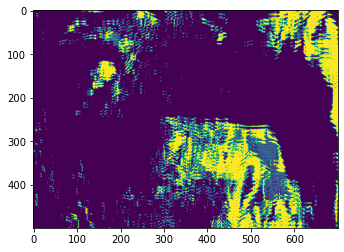

In [124]:
# Map of VIIRS over study area
img = h5py.File(Vfiles[0])
Vdata = img['geophysical_data'][cloud_var].value
plt.imshow(Vdata[1700:2200,2500:])

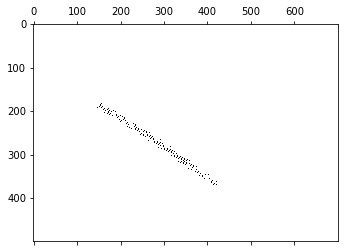

In [123]:
# Map of coincident Icesat-2 over study area
plt.spy(mask[1700:2200,2500:])

In [125]:
dataf.cloud_flg_asr.value_counts()

2    150480
1     93532
5     71058
3     49528
4     26321
0      4268
Name: cloud_flg_asr, dtype: int64

In [126]:
dataf.Integer_Cloud_Mask.value_counts()

3    108556
0     37503
1       192
Name: Integer_Cloud_Mask, dtype: int64

In [160]:
# Cloudy
ss = dataf[['Integer_Cloud_Mask','cloud_flg_asr']].loc[dataf.Integer_Cloud_Mask>=0]
ss = ss.loc[ss['Integer_Cloud_Mask']<=1]
allcld = ss.shape[0]
ss2 = ss.loc[ss['cloud_flg_asr']>=3]
matcld = ss2.shape[0]
matcld/allcld

0.8201352964584162

In [ ]:
# dataf.loc[dataf['t_year'].dt.date==f_day.date()]
# dataf['idx'] = idx
# plt.spy(mask[2500:,1700:2200])

# Xarray

In [50]:
%pylab inline
import xarray as xr

Populating the interactive namespace from numpy and matplotlib


/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
xray = xr.Dataset.from_dataframe(dataf)

In [62]:
xray

<xarray.Dataset>
Dimensions:             (index: 252416)
Coordinates:
  * index               (index) int64 0 1 2 3 4 ... 13174 13175 13176 13177
Data variables:
    ground_track        (index) object 'gt1l' 'gt1l' 'gt1l' ... 'gt3r' 'gt3r'
    lat                 (index) float64 68.08 68.08 68.08 ... 65.73 65.73 65.73
    lon                 (index) float64 -47.46 -47.46 -47.46 ... -49.08 -49.08
    h_li                (index) float32 1681.1671 1681.0332 ... 1479.2249
    s_li                (index) float32 0.008938037 0.012630311 ... 0.042509172
    q_flag              (index) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    s_fg                (index) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    snr                 (index) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    h_rb                (index) float32 0.11863171 0.13709156 ... 0.19301407
    dh_fit_dx           (index) float32 -0.006507039 ... -0.0005083084
    f_sn                (index) float32 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
    Integer_Cloud_Mask  (index) int8 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3

In [75]:
dataf.groupby('idx').h_li.mean()

idx
8869152     2413.775146
8872352     2412.567627
8875551     2411.411133
8878751     2408.125000
8878755     2401.977051
               ...     
10104314    1516.200317
10104319    1451.449829
10107518    1444.441284
10110717    1465.045532
10113917    1463.444580
Name: h_li, Length: 2475, dtype: float32

In [83]:
dataf.groupby(idx.flatten()).h_li.mean()

8869152     2413.775146
8872352     2412.567627
8875551     2411.411133
8878751     2408.125000
8878755     2401.977051
               ...     
10104314    1516.200317
10104319    1451.449829
10107518    1444.441284
10110717    1465.045532
10113917    1463.444580
Name: h_li, Length: 2475, dtype: float32

In [81]:
shape(idx.flat)

(252416,)

In [104]:
temp = xray.groupby('idx')

In [111]:
temp.reduce?

Signature: temp.reduce(func, dim=None, keep_attrs=None, **kwargs)
Docstring:
Reduce the items in this group by applying `func` along some
dimension(s).

Parameters
----------
func : function
    Function which can be called in the form
    `func(x, axis=axis, **kwargs)` to return the result of collapsing
    an np.ndarray over an integer valued axis.
dim : `...`, str or sequence of str, optional
    Dimension(s) over which to apply `func`.
axis : int or sequence of int, optional
    Axis(es) over which to apply `func`. Only one of the 'dimension'
    and 'axis' arguments can be supplied. If neither are supplied, then
    `func` is calculated over all dimension for each group item.
keep_attrs : bool, optional
    If True, the datasets's attributes (`attrs`) will be copied from
    the original object to the new one.  If False (default), the new
    object will be returned without attributes.
**kwargs : dict
    Additional keyword arguments passed on to `func`.

Returns
-------
reduced :

In [87]:
xr.DataArray(idx.flatten(),name='idx')

<xarray.DataArray 'idx' (dim_0: 252416)>
array([10024279, 10024279, 10024279, ...,  9202093,  9202093,  9202093])
Dimensions without coordinates: dim_0

In [97]:
xray.h_li[:50]

<xarray.DataArray 'h_li' (index: 50)>
array([1681.1671, 1681.0332, 1680.8826, 1680.7661, 1680.6771, 1680.5906,
       1680.5017, 1680.4003, 1680.3306, 1680.3057, 1680.2445, 1680.154 ,
       1680.0974, 1680.0483, 1679.9585, 1679.8813, 1679.8041, 1679.7041,
       1679.5951, 1679.5123, 1679.406 , 1679.2731, 1679.1458, 1679.0913,
       1679.0428, 1678.8878, 1678.7472, 1678.6771, 1678.5955, 1678.5282,
       1678.4364, 1678.2891, 1678.1946, 1678.114 , 1678.0094, 1677.9333,
       1677.8728, 1677.8041, 1677.7333, 1677.6865, 1677.6263, 1677.5552,
       1677.5076, 1677.4456, 1677.3518, 1677.2915, 1677.2076, 1677.1104,
       1677.0397, 1676.9884], dtype=float32)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49